# unzip the weather inmages

In [7]:
# import zipfile
# import os

# # Specify the path to the zip file
# zip_file_path = "dataset2_extracted/dataset2.zip"

# # # Specify the directory where you want to extract the contents
# # extract_to_directory = ""

# # # Create the directory if it doesn't exist
# # os.makedirs(extract_to_directory, exist_ok=True)

# # Open the zip file
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     # Extract all contents to the specified directory
#     zip_ref.extractall()

# print("Extraction completed successfully.")


Extraction completed successfully.


In [2]:
ls 

 ISIC_MobileNet-V2_finetune.ipynb                test.csv
 ISIC_MobileNet-V2_finetune_augmentation.ipynb   test_dup_image_confirmed.csv
 ISICmerge2019_2020_remove_dup_img.csv           test_feature.csv
 Preprocess_in_sagemaker.ipynb                   tmp/
 Untitled.ipynb                                  train.csv
 bank.ipynb                                      train.lst
 dataset2/                                      'unzip and load img.ipynb'
 isic/                                           validation.csv
'isic unzip and load img.ipynb'                  validation.lst
 isic_classification.ipynb                       weather_classification.ipynb
 missing_img.csv


In [13]:
import numpy as np
import pandas as pd
import os
import random
import shutil
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
%matplotlib inline

In [14]:

# Read the CSV file into a DataFrame
df = pd.read_csv('ISICmerge2019_2020_remove_dup_img.csv')


df = df.query('target != "unknown"')

print("\033[31m\033[1mHere is the training set:\033[0m\n")
display(df.head())
print('\n')

# Count the number of images in each class
class_counts = df['target'].value_counts().sort_index()

# Print the dataset summary
print("\033[32m\033[1mDataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in {i: label for i, label in enumerate(class_counts.index)}.items():
    count = class_counts.iloc[class_label]  # Use iloc to access elements by position
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")
print('\033[0m\n\n')


Here is the training set:



,image_id,patient_id,target,source,sex,age_approx,benign_malignant,anatom_site_general_challenge
2,ISIC_0052212.jpg,IP_2842074,nevus,ISIC2020,female,50.0,benign,lower extremity
12,ISIC_0076995.jpg,IP_2235340,nevus,ISIC2020,female,55.0,benign,torso
26,ISIC_0084086.jpg,IP_4023055,nevus,ISIC2020,male,60.0,benign,lower extremity
27,ISIC_0084270.jpg,IP_2961528,nevus,ISIC2020,male,40.0,benign,lower extremity
28,ISIC_0084395.jpg,IP_0175539,nevus,ISIC2020,female,45.0,benign,torso




Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               actinic keratoses              859       
1               basal cell carcinoma           3316      
2               dermatofibroma                 239       
3               keratosis                      2610      
4               melanoma                       5088      
5               nevus                          18042     
6               squamous cell carcinoma        628       
7               vascular skin                  253       
------------------------------------------------------------
Total                                         31035     





In [15]:
min_class = df.target.value_counts().min()
max_class = df.target.value_counts().max()

num_classes = len(df.target.unique())



# Specify the number of images to randomly select per class
#  = # print(min_class, num_classes)
num_images_per_class = min_class #@param ["min_class", "max_class"] {type:"raw"}


# List to store randomly selected images
selected_images = []

# Iterate over unique class labels in the DataFrame
for class_label in df['target'].unique():
    # Filter DataFrame for the current class
    class_data = df[df['target'] == class_label]

    if len(class_data) >= num_images_per_class:
            # Randomly select 'num_images_per_class' images for the current class
            selected_class_images = class_data.sample(num_images_per_class, random_state=42)
    else:
        # If not enough images, select all available images for the class
        selected_class_images = class_data

    # Append the selected images to the list
    selected_images.append(selected_class_images)

# Concatenate the selected images from all classes into a new DataFrame
selected_df = pd.concat(selected_images, ignore_index=True)
selected_df.target.value_counts()

target
nevus                      239
melanoma                   239
keratosis                  239
dermatofibroma             239
squamous cell carcinoma    239
basal cell carcinoma       239
vascular skin              239
actinic keratoses          239
Name: count, dtype: int64

In [7]:
import sagemaker, boto3, json
from sagemaker.session import Session

sagemaker_session = Session()
aws_role = sagemaker_session.get_caller_identity_arn()
aws_region = boto3.Session().region_name
sess = sagemaker.Session()
s3 = boto3.resource('s3', region_name=aws_region)
bucket = s3.Bucket('isic')

bucket_name = 'sagemaker-us-east-1-529165531209'

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [10]:
aws_role

'arn:aws:iam::529165531209:role/SagemakerFullAccess'

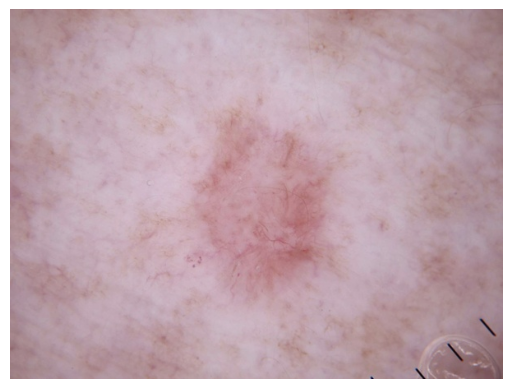

In [7]:
import boto3
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO

# Initialize S3 client
s3 = boto3.client('s3')

# Define the bucket name and key (object key) of the image to be displayed
bucket_name = 'sagemaker-us-east-1-529165531209'
image_key = 'isic_image/test/dermatofibroma/ISIC_0025154.jpg'  # Example image key\
# Retrieve the image object from S3
response = s3.get_object(Bucket=bucket_name, Key=image_key)
image_data = response['Body'].read()

# Open the image using PIL
img = Image.open(BytesIO(image_data))

# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axis
plt.show()

In [6]:
import boto3

# Initialize S3 client
s3 = boto3.client('s3')

# Bucket name and subfolder
bucket_name = 'sagemaker-us-east-1-529165531209'
subfolder = 'isic_image/basal cell carcinoma/'

# List objects in the specified subfolder
response = s3.list_objects_v2(Bucket=bucket_name, Prefix=subfolder)

# Count the number of images in the subfolder
num_images = len(response.get('Contents', []))

print(f"Number of images in the folder '{subfolder}': {num_images}")


Number of images in the folder 'isic_image/basal cell carcinoma/': 239


In [23]:
import boto3
import pandas as pd

# Initialize S3 client
s3 = boto3.client('s3')

# Bucket name and subfolder
bucket_name = 'sagemaker-us-east-1-529165531209'
subfolder = 'isic/selected_images/'

# Step 1: Retrieve the list of image IDs from selected_df
selected_image_ids = selected_df['image_id'].tolist()

# Step 2: List objects in the specified subfolder
response = s3.list_objects_v2(Bucket=bucket_name, Prefix=subfolder)

# Step 3: Extract image IDs from the S3 objects
s3_image_ids = [obj['Key'].split('/')[-1] for obj in response.get('Contents', [])]

# Step 4: Compare and calculate the number of missing images
missing_images = set(selected_image_ids) - set(s3_image_ids)
num_missing_images = len(missing_images)

print(f"Number of missing images: {num_missing_images}")

# Step 5: Create a DataFrame for the missing files
missing_df = pd.DataFrame({'image_id': list(missing_images)})

print("DataFrame for missing images:")
print(missing_df)


Number of missing images: 912
DataFrame for missing images:
             image_id
0    ISIC_0073099.jpg
1    ISIC_0061280.jpg
2    ISIC_0059349.jpg
3    ISIC_0064338.jpg
4    ISIC_0059014.jpg
..                ...
907  ISIC_0059985.jpg
908  ISIC_0062104.jpg
909  ISIC_0066860.jpg
910  ISIC_0058567.jpg
911  ISIC_0062359.jpg

[912 rows x 1 columns]


In [32]:
missing_df.to_csv('missing_img.csv', index = False)

In [31]:
image_id_series = pd.Series(missing_df['image_id'].values.tolist())

# Copy the Series to the clipboard
image_id_series.dtypes

dtype('O')

In [22]:
import boto3
import pandas as pd

# Initialize S3 client
s3 = boto3.client('s3')

# Bucket name and subfolder
bucket_name = 'sagemaker-us-east-1-529165531209'
subfolder = 'isic/selected_images/'

# Step 1: Retrieve the list of image IDs from selected_df
selected_image_ids = selected_df['image_id'].tolist()

# Step 2: List objects in the specified subfolder
response = s3.list_objects_v2(Bucket=bucket_name, Prefix=subfolder)

# Step 3: Extract image IDs from the S3 objects
s3_image_ids = [obj['Key'].split('/')[-1] for obj in response.get('Contents', [])]

# Step 4: Compare and calculate the number of missing images
missing_images = set(selected_image_ids) - set(s3_image_ids)

# Step 5: Copy missing images to the subfolder in the S3 bucket
for image_id in missing_images:
    # Replace 'source_dir' with the actual path to the directory containing the missing images
    source_path = f"source_dir/{image_id}"
    # Construct the target S3 key
    target_key = f"{subfolder}/{image_id}"
    # Upload the image file to S3
    s3.upload_file(source_path, bucket_name, target_key)
    print(f"Uploaded {image_id} to {target_key}")

print("Upload completed.")


FileNotFoundError: [Errno 2] No such file or directory: 'source_dir/ISIC_0073099.jpg'

In [19]:
import os
import pandas as pd

# Directory containing the images
subfolder = 'isic/selected_images/'

# Read the DataFrame
df = pd.read_csv('ISICmerge2019_2020_remove_dup_img.csv')

# Initialize a dictionary to store the count of images for each target
target_count = {}

# Iterate over each file in the subfolder
for filename in os.listdir(subfolder):
    if filename.endswith('.jpg'):
        # Extract the image ID from the filename
        image_id = filename.split('.')[0]
        
        # Check if the image ID exists in the DataFrame
        if image_id in df['image_id'].values:
            # Get the target corresponding to the image ID
            target = df.loc[df['image_id'] == image_id, 'target'].iloc[0]
            
            # Increment the count for the target
            if target in target_count:
                target_count[target] += 1
            else:
                target_count[target] = 1

# Print the count of images for each target
for target, count in target_count.items():
    print(f"Target: {target}, Count: {count}")


In [18]:
# Create a directory to store the images for each target

bucket_name = 'sagemaker-us-east-1-529165531209'
subfolder = 'isic/selected_images/'

for target in selected_df['target'].unique():
    target_dir = os.path.join(subfolder, target)
    os.makedirs(target_dir, exist_ok=True)

# Copy selected images to the corresponding target folders
for index, row in df.iterrows():
    image_filename = row['image_id']
    target = row['target']
    source_path = os.path.join(subfolder, image_filename)
    target_path = os.path.join(subfolder, target, image_filename)
    shutil.copyfile(source_path, target_path)
    print(f"Copied {image_filename} to {target_path}")

print("Image loading completed.")

FileNotFoundError: [Errno 2] No such file or directory: 'isic/selected_images/ISIC_0052212.jpg'

In [ ]:
import boto3
import zipfile
import pandas as pd

# Read the CSV file containing image information
df = pd.read_csv('ISICmerge2019_2020_remove_dup_img.csv')

# Specify the S3 bucket name and key for the zip file
bucket_name = 'sagemaker-us-east-1-529165531209'
zip_file_key = 'isic/isic_images.zip'

# Function to extract images from the zip file
def extract_images():
    s3 = boto3.client('s3')
    extracted_count = 0
    
    # Download and extract the zip file from S3
    zip_file_obj = s3.get_object(Bucket=bucket_name, Key=zip_file_key)
    zip_file_bytes = zip_file_obj['Body'].read()
    
    # Open the zip file
    with zipfile.ZipFile(BytesIO(zip_file_bytes)) as zip_ref:
        for file_info in zip_ref.infolist():
            # Check if the file is a regular file (not a directory)
            if file_info.is_file():
                # Extract the file
                zip_ref.extract(file_info.filename)
                extracted_count += 1
                print(f"Extracted {file_info.filename}")
    
    return extracted_count

# Extract images from the zip file
total_extracted = extract_images()

print(f"Total images extracted: {total_extracted}")


In [ ]:
import boto3
import zipfile
from PIL import Image
from io import BytesIO
import pandas as pd

# # Read the CSV file containing image information
# df = pd.read_csv('ISICmerge2019_2020_remove_dup_img.csv')

# Specify the S3 bucket name and key for the zip file
bucket_name = 'sagemaker-us-east-1-529165531209'
zip_file_key = 'isic/isic_images.zip'

# # Select the images from the DataFrame to load
# selected_df = df[df['image_id'].isin(selected_df['image_id'])]

# Initialize S3 client
s3 = boto3.client('s3')

# Download and extract the zip file from S3
zip_file_obj = s3.get_object(Bucket=bucket_name, Key=zip_file_key)
zip_file_bytes = zip_file_obj['Body'].read()

# Open the zip file
with zipfile.ZipFile(BytesIO(zip_file_bytes)) as zip_ref:
    # Iterate over selected images from the DataFrame
    for index, row in selected_df.iterrows():
        # Get the filename of the selected image
        image_filename = row['filename']
        
        # Check if the file exists in the zip file
        if image_filename in zip_ref.namelist():
            # Read and resize the image
            with zip_ref.open(image_filename) as image_file:
                img = Image.open(image_file)
                img_resized = img.resize((224, 224), resample=Image.LANCZOS)
                
                # Convert the resized image to bytes
                with BytesIO() as output:
                    img_resized.save(output, format='JPEG')
                    image_data = output.getvalue()
                
                # Determine the folder and subfolder paths
                folder = 'train' if row['target'] == 'train' else 'validation' if row['target'] == 'validation' else 'test'
                subfolder = row['target']
                
                # Upload the resized image data to the corresponding folder and subfolder in S3 bucket
                s3_key = f"isic/selected_images/{folder}/{subfolder}/{image_filename}"
                s3.put_object(Bucket=bucket_name, Key=s3_key, Body=image_data)
                # print(f"Uploaded {image_filename} to S3 bucket {bucket_name} with key {s3_key}")
        else:
            print(f"Error: {image_filename} not found in the zip file.")


In [ ]:
import boto3
import zipfile
from PIL import Image
from io import BytesIO
import pandas as pd

# Read the CSV file containing image information
df = pd.read_csv('ISICmerge2019_2020_remove_dup_img.csv')

# Specify the S3 bucket name and key for the zip file
bucket_name = 'sagemaker-us-east-1-529165531209'
zip_file_key = 'isic/isic_images.zip'

# Select the images from the DataFrame to load
selected_df = df[df['image_id'].isin(df['image_id'])]  # Assuming you want to select all images

# Initialize S3 client
s3 = boto3.client('s3')

# Download and extract the zip file from S3
zip_file_obj = s3.get_object(Bucket=bucket_name, Key=zip_file_key)
zip_file_bytes = zip_file_obj['Body'].read()

# Open the zip file
with zipfile.ZipFile(BytesIO(zip_file_bytes)) as zip_ref:
    # Iterate over selected images from the DataFrame
    for index, row in selected_df.iterrows():
        # Get the filename of the selected image
        image_filename = row['filename']
        
        # Check if the file exists in the zip file
        if image_filename in zip_ref.namelist():
            # Read and resize the image
            with zip_ref.open(image_filename) as image_file:
                img = Image.open(image_file)
                img_resized = img.resize((224, 224), resample=Image.LANCZOS)
                
                # Convert the resized image to bytes
                with BytesIO() as output:
                    img_resized.save(output, format='JPEG')
                    image_data = output.getvalue()
                
                # Determine the folder and subfolder paths
                folder = 'train' if row['target'] == 'train' else 'validation' if row['target'] == 'validation' else 'test'
                subfolder = row['target']
                
                # Upload the resized image data to the corresponding folder and subfolder in S3 bucket
                s3_key = f"isic/selected_images/{folder}/{subfolder}/{image_filename}"
                s3.put_object(Bucket=bucket_name, Key=s3_key, Body=image_data)
                # print(f"Uploaded {image_filename} to S3 bucket {bucket_name} with key {s3_key}")
        else:
            print(f"Error: {image_filename} not found in the zip file.")


In [22]:
# Splits the images into 80% training, 10% validation, and 10% testing
split_1 = int(0.8 * len(files))
split_2 = int(0.9 * len(files))

train_filenames = files[:split_1]
val_filenames = files[split_1:split_2]
test_filenames = files[split_2:]

print("Training filenames:")
for file in train_filenames[:3]:
    print(file)

print("\nValidation filenames:")
for file in val_filenames[:3]:
    print(file)

print("\nTesting filenames:")
for file in test_filenames[:3]:
    print(file)


Training filenames:
dataset2/sunrise125.jpg
dataset2/cloudy269.jpg
dataset2/rain205.jpg

Validation filenames:
dataset2/sunrise218.jpg
dataset2/rain136.jpg
dataset2/sunrise272.jpg

Testing filenames:
dataset2/cloudy251.jpg
dataset2/cloudy80.jpg
dataset2/cloudy134.jpg


# create folders and load images files into those folders

In [27]:
import boto3
from PIL import Image
import os

# Initialize S3 client
s3 = boto3.client('s3')

# Define the bucket name
bucket_name = 'sagemaker-us-east-1-529165531209'

# Define the subfolder name
subfolder_name = 'weather_classification'

# Define the folder names
folders = ['train', 'validation', 'test']

# Create the subfolder in S3 bucket
s3.put_object(Bucket=bucket_name, Key=(subfolder_name+'/'))

# Loop through each folder
for folder in folders:
    # Create the folder in S3 bucket under the subfolder
    s3.put_object(Bucket=bucket_name, Key=(subfolder_name+'/'+folder+'/'))

# Define the image size for resizing
image_size = (224, 224)

# Define the folders containing filenames
folders_filenames = {'train': train_filenames, 'validation': val_filenames, 'test': test_filenames}

# Loop through each folder and its filenames
for folder, filenames in folders_filenames.items():
    # Loop through each filename in the folder
    for filename in filenames:
        # Open the image file
        with Image.open(filename) as img:
            # Resize the image
            if img.mode != 'RGB':
                img = img.convert('RGB')
                
            img_resized = img.resize(image_size, resample=Image.LANCZOS)  # Using LANCZOS interpolation for antialiasing
            # Convert image to bytes
            img_bytes = BytesIO()
            img_resized.save(img_bytes, format='JPEG')
            img_bytes.seek(0)

            s3_key = os.path.join(subfolder_name, folder, os.path.basename(filename))
            # Upload the resized image to S3 bucket in the corresponding folder
            s3.put_object(Bucket=bucket_name, Key=s3_key, Body=img_bytes)
            # print(f"Uploaded {s3_key} to S3 bucket {bucket_name}/{folder} after resizing.")

print("Image resizing and upload completed successfully.")


Image resizing and upload completed successfully.


Create the metadata file(lst file). The file should be in the format of

image_index, label, image_name/image_path

Since this is a multilabel classification problem

image_index, label_1, label_2,..label_n, image_name/image_path

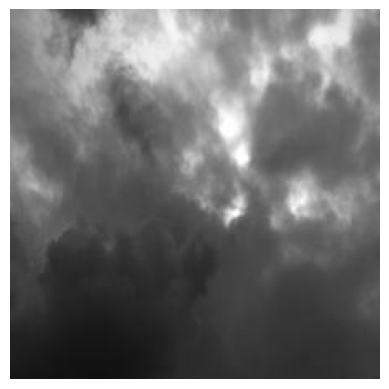

In [28]:
import boto3
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO

# Initialize S3 client
s3 = boto3.client('s3')

# Define the bucket name and key (object key) of the image to be displayed
bucket_name = 'sagemaker-us-east-1-529165531209'
image_key = 'weather_classification/train/cloudy1.jpg'  # Example image key

# Retrieve the image object from S3
response = s3.get_object(Bucket=bucket_name, Key=image_key)
image_data = response['Body'].read()

# Open the image using PIL
img = Image.open(BytesIO(image_data))

# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axis
plt.show()


In [6]:
import boto3
import pandas as pd
from io import StringIO

# Initialize S3 client
s3 = boto3.client('s3')

# Define the bucket name
# bucket_name = 'sagemaker-us-west-2-529165531209'
bucket_name = 'sagemaker-us-east-1-529165531209'

# Function to get labels based on file names
def get_label(file):
    if 'cloudy' in file:
        return 0
    elif 'rain' in file:
        return 1
    elif 'shine' in file:
        return 2
    else:
        return 3

# Function to create DataFrame from S3 folder
def create_dataframe_from_s3_folder(folder_name):
    df = pd.DataFrame()
    filenames = []
    labels = []
    
    # List objects in the S3 folder
    response = s3.list_objects_v2(Bucket=bucket_name, Prefix=folder_name)
    for obj in response.get('Contents', []):
        filenames.append(obj['Key'])
        labels.append(get_label(obj['Key']))
    
    # Create DataFrame
    df['labels'] = labels
    df['s3_path'] = filenames
    df = df.reset_index().rename(columns={'index':'row_id'})
    df = pd.concat([df, pd.get_dummies(df['labels'], prefix='label')], axis=1).drop('labels', axis=1)
    new_columns = ['row_id', 'label_0', 'label_1', 'label_2', 'label_3', 's3_path']
    df = df.reindex(columns=new_columns)
    return df

# Create DataFrame for training set
train_df = create_dataframe_from_s3_folder('train/')


# Create DataFrame for validation set
validation_df = create_dataframe_from_s3_folder('validation/')



In [35]:
# train_df.fillna('False', inplace = True)
# train_df = train_df.replace(True,1)
# train_df = train_df.replace(False,0)
# train_df = train_df.replace('False',0)
# train_df = train_df.iloc[1:,:]
train_df.head()

,row_id,label_0,label_1,label_2,label_3,s3_path
1,1,1,0,0,0,cloudy1.jpg
2,2,1,0,0,0,cloudy10.jpg
3,3,1,0,0,0,cloudy100.jpg
4,4,1,0,0,0,cloudy101.jpg
5,5,1,0,0,0,cloudy102.jpg


In [34]:
train_df['s3_path'] = train_df.iloc[:,-1].apply(lambda x: x.replace('train/',''))

In [8]:
# validation_df.fillna('False', inplace = True)
# validation_df = validation_df.replace(True,1)
# validation_df = validation_df.replace(False,0)
# validation_df = validation_df.replace('False',0)
# validation_df = validation_df.iloc[1:,:]
validation_df.head()

,row_id,label_0,label_1,label_2,label_3,s3_path
1,1,1,0,0,0,validation/cloudy103.jpg
2,2,1,0,0,0,validation/cloudy116.jpg
3,3,1,0,0,0,validation/cloudy129.jpg
4,4,1,0,0,0,validation/cloudy13.jpg
5,5,1,0,0,0,validation/cloudy138.jpg


In [36]:
validation_df['s3_path'] = validation_df.iloc[:,-1].apply(lambda x: x.replace('validation/',''))

In [37]:
# validation_df.head()

# load the files to the bucket

In [38]:
from io import StringIO
import boto3
import pandas as pd

# Initialize S3 client
s3 = boto3.client('s3')

# Define the bucket name
# bucket_name = 'sagemaker-us-west-2-529165531209'
bucket_name = 'sagemaker-us-east-1-529165531209'

# Function to upload DataFrame to S3
def upload_dataframe_to_s3(dataframe, filename, bucket_name):
    csv_buffer = StringIO()
    dataframe.to_csv(csv_buffer, sep='\t', index=False, header=False)
    response = s3.put_object(Bucket=bucket_name, Key=filename, Body=csv_buffer.getvalue())
    print(f"Uploaded DataFrame to S3 bucket {bucket_name}/{filename}")

# Load train_df to S3
upload_dataframe_to_s3(train_df, 'train.lst', bucket_name)

# Load validation_df to S3
upload_dataframe_to_s3(validation_df, 'validation.lst', bucket_name)


Uploaded DataFrame to S3 bucket sagemaker-us-east-1-529165531209/train.lst
Uploaded DataFrame to S3 bucket sagemaker-us-east-1-529165531209/validation.lst


In [10]:
train_df.to_csv('train.lst', sep='\t', index=False, header=False)
validation_df.to_csv('validation.lst', sep='\t', index=False, header=False)

In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import boto3
from PIL import Image

# Initialize S3 client
s3 = boto3.client('s3')

# Download the image from S3
bucket_name = 'sagemaker-us-west-2-529165531209'
image_key = 'weather_classification/train/cloudy1.jpg'
local_file = 'cloudy10.jpg'

try:
    s3.download_file(bucket_name, image_key, local_file)

    # Open the image file
    img = Image.open(local_file)

    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()

except Exception as e:
    print("Error:", e)


Error: cannot identify image file 'cloudy10.jpg'


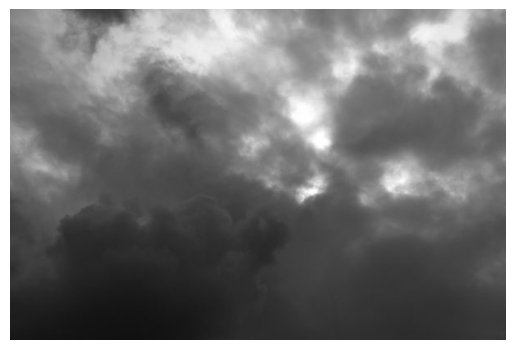

In [13]:
img = Image.open('dataset2/cloudy1.jpg')

# Display the image
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()


In [15]:
# Show the original size of the image
print("Original image size:", img.size)

# Resize the image to 224 x 224
resized_img = img.resize((224, 224))

# Show the size of the resized image
print("Resized image size:", resized_img.size)


Original image size: (600, 400)
Resized image size: (224, 224)


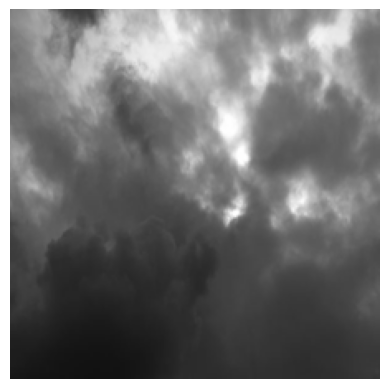

In [16]:
plt.imshow(resized_img)
plt.axis('off')  # Hide axes
plt.show()

Resized image size: (224, 224)


(-0.5, 223.5, 223.5, -0.5)

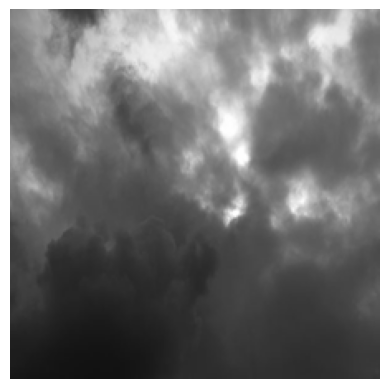

In [20]:
resized_img2 = img.resize((224, 224), resample=Image.LANCZOS)   # Use ANTIALIAS interpolation for better quality

# Show the size of the resized image
print("Resized image size:", resized_img2.size)

# Display the resized image
plt.imshow(resized_img2)
plt.axis('off')